### Multi-class regression (일명 Softmax regression).

In [1]:
import os
import pandas as pd
import numpy as np
import warnings
#from google.colab import drive
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.datasets import load_iris
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')                              # Turn the warnings off.
%matplotlib inline

#### 1. 데이터 불러오고 준비:

In [2]:
# 내장 데이터 불러오기.
data_raw = load_iris()
X = data_raw['data']
y0 = data_raw['target'].reshape(-1,1)

In [3]:
# y를 one-hot-encoding된 형태로 변환한다.
y = to_categorical(y0, num_classes=3)
y[:3,:]

array([[1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.]], dtype=float32)

In [4]:
# DataFrame으로 출력해서 보기.
header = ['SepalLength','SepalWidth','PetalLength','PetalWidth','Species_0', 'Species_1', 'Species_2']
df = pd.DataFrame(np.concatenate([X,y],axis=1),columns=header)
df.head(5)

,SepalLength,SepalWidth,PetalLength,PetalWidth,Species_0,Species_1,Species_2
0,5.1,3.5,1.4,0.2,1.0,0.0,0.0
1,4.9,3.0,1.4,0.2,1.0,0.0,0.0
2,4.7,3.2,1.3,0.2,1.0,0.0,0.0
3,4.6,3.1,1.5,0.2,1.0,0.0,0.0
4,5.0,3.6,1.4,0.2,1.0,0.0,0.0


In [5]:
# 데이터 쪼개기.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)
n_vars = X_train.shape[1]

In [6]:
# X를 스케일링 한다.
# X를 스케일링 해주어야 학습이 잘 된다!
my_scaler = MinMaxScaler()
my_scaler.fit(X_train)                           # X_train만 가지고 스케일러 학습 실행!
X_train = my_scaler.transform(X_train)
X_test = my_scaler.transform(X_test)

#### 2. Sequential API model 정의:

In [7]:
# Sequential object 객체에 layer 추가.
my_model = Sequential()
my_model.add(Dense(input_dim=n_vars, units = 3, activation="softmax"))    # units = N# of output variables.

In [8]:
# 모델의 summary (내부 구조) 출력.
# 파라미터의 수 = n_vars * n_output + n_output = 4*3 + 3 = 15.
my_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 3)                 15        
                                                                 
Total params: 15
Trainable params: 15
Non-trainable params: 0
_________________________________________________________________


#### 3. Hyperparameter 와 Optimizer 정의:

In [9]:
# Hyperparameters.
n_epochs = 500
batch_size = 32
learn_rate = 0.002

In [10]:
# Optimizer 객체 생성 후 컴파일한다.
my_optimizer=Adam(lr=learn_rate)
my_model.compile(loss = "categorical_crossentropy", optimizer = my_optimizer, metrics=["accuracy"])

#### 4. 학습 & History 시각화:

In [11]:
# 학습.
# verbose = 0 : 출력 없음. verbose = 1 : 출력 함.
my_summary = my_model.fit(X_train, y_train, epochs=n_epochs, batch_size = batch_size, validation_split = 0.2, verbose = 0)

In [12]:
# 학습된 파라미터 출력.
print("Weights : ", my_model.layers[0].get_weights()[0])
print("Bias    : ", my_model.layers[0].get_weights()[1])

Weights :  [[-0.6930982   1.3082253   2.01952   ]
 [ 1.7959145  -1.9048518  -1.1959659 ]
 [-1.8205851   0.6760039   1.079893  ]
 [-0.8990787   0.97722745  2.4298363 ]]
Bias    :  [ 1.0511582  0.5229821 -1.4205287]


In [13]:
# 학습 history의 key 확인.
my_summary.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

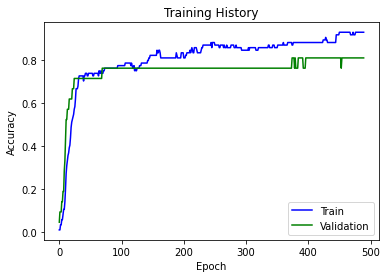

In [14]:
# 학습 history 출력. 
n_skip = 10                 # Skip the first few steps.
plt.plot(my_summary.history['accuracy'][n_skip:], c="b")
plt.plot(my_summary.history['val_accuracy'][n_skip:], c="g")
plt.title('Training History')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.show()

#### 5. 테스팅: 

In [15]:
# 예측된 유형.
y_pred = np.argmax(my_model.predict(X_test), axis=1)
y_pred

2/2 [==============================] - 0s 2ms/step


array([1, 2, 2, 1, 0, 1, 1, 0, 0, 1, 2, 0, 1, 2, 2, 2, 0, 0, 1, 0, 0, 1,
       0, 1, 0, 0, 0, 1, 2, 0, 2, 1, 0, 0, 1, 1, 2, 0, 0, 1, 1, 0, 2, 2,
       1], dtype=int64)

In [16]:
# 실제 유형.
y_true = np.argmax(y_test, axis=1)
y_true

array([1, 2, 2, 1, 0, 2, 1, 0, 0, 1, 2, 0, 1, 2, 2, 2, 0, 0, 1, 0, 0, 2,
       0, 2, 0, 0, 0, 2, 2, 0, 2, 2, 0, 0, 1, 1, 2, 0, 0, 1, 1, 0, 2, 2,
       2], dtype=int64)

In [17]:
# 정확도 계산.
np.round(np.mean(y_pred == y_true),3)

0.867

In [18]:
# evaluate() 메소드를 사용해서 계산.
ACC = my_model.evaluate(X_test, y_test, verbose=0)[1]  
print("Test Accuracy : {}".format(np.round(ACC,3)))

Test Accuracy : 0.867


#### 6. 모델 저장.

In [19]:
#drive.mount('/content/drive') # 드라이브를 마운팅 한다.
#os.chdir("/content/drive/My Drive/Colab Notebooks")

In [20]:
# 학습된 모델을 HDF5 표준을 사용해서 저장해둠.
my_model.save("my_model.h5")

In [21]:
# 저장된 모델을 불러옴.
my_model_saved = load_model("my_model.h5")

In [22]:
# 불러온 모델을 사용해서 테스트 해봄.
ACC = my_model_saved.evaluate(X_test, y_test, verbose=0)[1]    
print("Test Accuracy : {}".format(np.round(ACC,3)))

Test Accuracy : 0.867
